# **Quantifying Above Ground Biomass of Logan Campus, Griffith University's Arboretum from satellite data using Machine Learning methods.**

This notebook contains scripts for vegetation indices extraction, donwload, creation of training data and Machine Learning models for predicting Above Ground Biomass for Griffith University's Arboretum. All the processes used are explained in the MarkUp.


The preliminary task performed on QGIS software is to digitize the arboretum outlines. The resulting shapefile was uploaded to google drive for easier retrieval

## **Installing the key libraries**

In [ ]:
# Installing and importing geemap
try:
    import geemap
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print('geemap not found, installing via pip in Google Colab...')
        ! pip install geemap --quiet
        import geemap
    else:
        print('geemap not found, please install via conda in your environment')

In [ ]:
! pip install geopandas

###**Import libraries and authenticate Earth Engine**

In [ ]:
# Import the libraries
import geemap
import ee
import geopandas as gpd
import random
import pandas as pd

In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize(project='gacheri')

###**Import Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Initializing Geemap**

In [ ]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## **Reading the data**

In [ ]:
# Area of interest - the shapefile digitized on the GIS software
arboretum_shp = gpd.read_file("/content/drive/MyDrive/Griffith Logan/Logan_Campus/Logan_arb.shp")
aoi = geemap.geopandas_to_ee(arboretum_shp)
Map.addLayer(aoi, {}, "Area of Interest")
Map.centerObject(aoi, 17); # Center shp and Zoom 17X
Map

Map(center=[-27.665074088348057, 153.1557239585474], controls=(WidgetControl(options=['position', 'transparent…

## **Functions for Calculating Indices**

###**NDVI**

In [ ]:
# Normalized Difference Vegetation Index
def getNDVI(image):
    # Compute the NDVI using an expression.
    return image.addBands(
        image.expression(
            '((NIR - RED) / (NIR + RED))',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4')
            }
        ).rename("NDVI")
    )

###**MSAVI**

In [ ]:
# MSAVI (Modified Soil Adjusted Vegetation Index)
def getMSAVI(image):
    return image.addBands(
        image.expression(
            '(2 * NIR + 1 - sqrt((2 * NIR + 1) ** 2 - 8 * (NIR - RED))) / 2',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4')
            }
        ).rename("MSAVI")
    )

###**EVI**

In [ ]:
# Enhanced Vegetation Index
# EVI formula derived from (Jinru & Baofeng, 2017)'s
# Article title - Significant Remote Sensing Vegetation Indices: A Review of Developments and Applications
def getEVI(image):
    return image.addBands(
        image.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {
                'NIR': image.select('B8').divide(10000),
                'RED': image.select('B4').divide(10000),
                'BLUE': image.select('B2').divide(10000)
            }
        ).rename("EVI")
    )

###**LAI**

In [ ]:
# LAI - Leaf Area Index
# Cited from (Tri et al 2018)
# Article name - Selection of vegetation indices for mapping the sugarcane condition
# around the oil and gas field of North West Java Basin, Indonesia
def getLAI(image):
    return image.addBands(
        image.expression(
            '(3.618 * EVI - 0.118)',
            {
                'EVI': image.select('EVI')
            }
        ).rename("LAI")
    )

###**RGR**

In [ ]:
# RGR (Red Green Ratio)
def getRGR(image):
    return image.addBands(
        image.expression(
            '(RED / GREEN)',
            {
                'RED': image.select('B4'),
                'GREEN': image.select('B3')
            }
        ).rename("RGR")
    )

###**RGI**

In [ ]:
# RGI (Red Green Index)
def getRGI(image):
    return image.addBands(
        image.expression(
            '((GREEN - RED) / (GREEN + RED))',
            {
                'GREEN': image.select('B3'),
                'RED': image.select('B4')
            }
        ).rename("RGI")
    )

### **OSAVI**

In [ ]:
# OSAVI Optimized Soil Adjusted Vegetation Index
def getOSAVI(image):
    return image.addBands(
        image.expression(
            '((NIR - RED) / (NIR + RED + 0.16))',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4')
            }
        ).rename("OSAVI")
    )

### **AGB Estimates**

In [ ]:
# Aboveground - estimated using AGB = 14.046 + 272.496 RGI, from
#Oktian, S. H., Adinugroho, W. C., Anen, N., & Setyaningsih, L. (2022).
#Aboveground Carbon Stock Estimation Model Using Sentinel-2A Imagery in Mbeliling
#Lanscape in Nusa Tenggara Timur, Indonesia. KnE Life Sciences, 368-381.
def getAGB(image):
    return image.addBands(
        image.expression(
            '14.046 + 272.496 * RGI',
            {
                'RGI': image.select('RGI')
            }
        ).rename("AGB")
    )

###**Date**

In [ ]:
# manage the date formating as per your requirements
# Mine is in format of YYYYMMdd
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('date').toInt())

##**Image Collections**

According to this [presentation](https://prezi.com/view/hQL6ys3RtNNRiVN44s5a/) the forest was planted in 2013. Lets begin our analysis in 2015 (when GEE data became available) for each 2-year epochs.

**Function for masking clouds**

In [ ]:
def maskS2clouds(image):
    band_names = image.bandNames()

    # Check if 'QA60' exists in the image
    condition = band_names.contains('QA60')

    # If present, apply cloud masking
    def apply_mask():
        qa = image.select('QA60')
        cloudBitMask = 1 << 10
        cirrusBitMask = 1 << 11
        mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
               qa.bitwiseAnd(cirrusBitMask).eq(0))
        return image.updateMask(mask)

    # If QA60 is missing, return the original image
    return ee.Image(ee.Algorithms.If(condition, apply_mask(), image))

In [ ]:
# Function for obtaining all the image collections while removing the redundancies
def process_s2_imagery(year, aoi):
    # Image collection for the specified year
    s2 = ee.ImageCollection('COPERNICUS/S2') \
        .filterDate(f'{year}-01-01', f'{year}-12-31') \
        .filterBounds(aoi) \
        .map(maskS2clouds) \
        .filter(ee.Filter.listContains('system:band_names', 'B2')) \
        .filter(ee.Filter.listContains('system:band_names', 'B3')) \
        .filter(ee.Filter.listContains('system:band_names', 'B4')) \
        .filter(ee.Filter.listContains('system:band_names', 'B8')) \
        .map(getNDVI) \
        .map(getMSAVI) \
        .map(getEVI) \
        .map(getLAI) \
        .map(getRGR) \
        .map(getRGI) \
        .map(getOSAVI) \
        .map(getAGB) \
        .map(addDate)

    # Calculate median value of the imagery collection
    s2_median = s2.median()
    return s2, s2_median

In [ ]:
# Applying our process_s2_imagery function to the different years.
# col_{year} represents the collection, while med_{year} represents the median image

# For 2015
col_15, med_15 = process_s2_imagery(2015, aoi)
# For 2016
col_16, med_16 = process_s2_imagery(2016, aoi)
# For 2017
col_17, med_17 = process_s2_imagery(2017, aoi)
# For 2018
col_18, med_18 = process_s2_imagery(2018, aoi)
# For 2019
col_19, med_19 = process_s2_imagery(2019, aoi)
# For 2020
col_20, med_20 = process_s2_imagery(2020, aoi)
# For 2021
col_21, med_21 = process_s2_imagery(2021, aoi)
# For 2022
col_22, med_22 = process_s2_imagery(2022, aoi)

##**Visualization of Generated Indices**

###**Color Palettes**

In [ ]:
# Define the color palette for the NDVI, RGR, LAI and EVI layers
ndvi_colors = ['#FF0000', '#FFFF00', '#00FF00' ]  # green, yellow, red
msavi_colors = ['white', 'yellow', 'brown']
evi_colors = ['#0000FF', '#00FFFF', '#FFFF00', '#FF0000']  # blue, cyan, yellow, red
lai_colors = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
    '74A901', '66A000', '529400', '3E8601', '207401', '056201',
    '004C00', '023B01', '012E01', '011D01', '011301']
rgr_colors = ['#FF0000', '#FFFFFF', '#00FF00']  # red, white, green
rgi_colors = ['yellow','orange', 'brown']  # yellow, orange, brown
osavi_colors = ['white', 'yellow', 'brown']
agb_colors = ['blue','white', 'brown']

In [ ]:
palette_ndvi = {"min":0.2, "max":0.8, 'palette':ndvi_colors}
palette_msavi = {"min": 0.2, "max": 0.8, 'palette':msavi_colors}
palette_evi = {"min":0.2, "max":0.8, 'palette':evi_colors}
palette_lai = {"min": 0.2, "max": 3.5, 'palette': lai_colors}
palette_rgr = {"min":0.7, "max":1.0, 'palette':rgr_colors}
palette_rgi = {"min":-0.1, "max":0.5, 'palette':rgi_colors}
palette_osavi = {"min": 0.3, "max": 1.0, 'palette':osavi_colors}
palette_agb = {"min":20, "max":80, 'palette':agb_colors}

In [ ]:
# Function for visualizing the different indices for different years
def indices_visualization(index, years, aoi, palette):
  Map = geemap.Map()
  Map.centerObject(aoi, 17)

  for year in years:
    # Process Sentinel-2 imagery for the year
    s2, s2_median = process_s2_imagery(year, aoi)

    # Add layers to the map
    Map.addLayer(s2_median.clip(aoi).select(index), palette, f"{index}_{year}")

  Map.addLayerControl()

  # Add a color bar for the layer
  Map.add_colorbar(palette, label=index, layer_name=index, orientation="horizontal", transparent_bg=True)

  return Map

###**NDVI Maps**

Switch layers on and off by clicking the layers icon. Can also zoom in and out.

In [ ]:
# NDVI all years
index = "NDVI"
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Map = indices_visualization(index, years, aoi, palette_ndvi)
Map

Map(center=[-27.665074088348057, 153.1557239585474], controls=(WidgetControl(options=['position', 'transparent…

###**MSAVI Maps**

In [ ]:
# NDVI all years
index = "MSAVI"
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Map = indices_visualization(index, years, aoi, palette_ndvi)
Map

Map(center=[-27.665074088348057, 153.1557239585474], controls=(WidgetControl(options=['position', 'transparent…

###**EVI Maps**

In [ ]:
# EVI all years
index = "EVI"
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Map = indices_visualization(index, years, aoi, palette_msavi)
Map

Map(center=[-27.665074088348057, 153.1557239585474], controls=(WidgetControl(options=['position', 'transparent…

###**LAI Maps**

In [ ]:
# LAI all years
index = "LAI"
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Map = indices_visualization(index, years, aoi, palette_lai)
Map

Map(center=[-27.665074088333316, 153.15572395855574], controls=(WidgetControl(options=['position', 'transparen…

###**RGR Maps**

In [ ]:
# RGR all years
index = "RGR"
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Map = indices_visualization(index, years, aoi, palette_rgr)
Map

Map(center=[-27.665074088348057, 153.1557239585474], controls=(WidgetControl(options=['position', 'transparent…

###**RGI Maps**

In [ ]:
# RGI all years
index = "RGI"
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Map = indices_visualization(index, years, aoi, palette_rgi)
Map

Map(center=[-27.665074088348057, 153.1557239585474], controls=(WidgetControl(options=['position', 'transparent…

### **OSAVI Maps**

In [ ]:
# OSAVI all years
index = "OSAVI"
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Map = indices_visualization(index, years, aoi, palette_osavi)
Map

Map(center=[-27.665074088348057, 153.1557239585474], controls=(WidgetControl(options=['position', 'transparent…

###**AGB Maps**

In [ ]:
# AGB all years
index = "AGB"
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Map = indices_visualization(index, years, aoi, palette_agb)
Map

Map(center=[-27.665074088348057, 153.1557239585474], controls=(WidgetControl(options=['position', 'transparent…

**Visualizing the indices, side-by-side**

Change the index variable, and the palette argument to visualize the other indices, side-by-side

In [ ]:
# Create an empty list to store the maps
maps = []

# Define the index and years for which you want to create maps
index = "NDVI" # Change here
years = range(2015, 2023)
from ipywidgets import HBox

maps = [indices_visualization(index, [year], aoi, palette_ndvi) for year in years] # And here
HBox([map for map in maps])


###**Function for exporting the Indices**

In [ ]:
def indices_export(indices, years, aoi):# Rename
    # Create the map
    Map = geemap.Map()
    Map.centerObject(aoi, 17)

    # Initialize empty lists to store the images for each index
    index_images = {index: [] for index in indices}
    palettes = {'NDVI': palette_ndvi, 'MSAVI': palette_msavi, 'EVI': palette_evi, 'LAI': palette_lai, 'RGR': palette_rgr, 'RGI': palette_rgi, 'OSAVI': palette_osavi, 'AGB': palette_agb}

    # Process Sentinel-2 imagery for each year
    for year in years:
        # Process Sentinel-2 imagery for the year
        s2, s2_median = process_s2_imagery(year, aoi)

        # Add layers to the map and append the images to their respective lists
        for index in indices:
            Map.addLayer(s2_median.clip(aoi).select(index), palettes[index], f"{index}_{year}")
            index_images[index].append(s2_median.clip(aoi).select(index))

    Map.addLayerControl()

    # Add a color bar for each index layer
    for index in indices:
        Map.add_colorbar(palettes[index], label=index, layer_name=index, orientation="horizontal", transparent_bg=True)

    return Map, index_images


In [ ]:
# We call the function
indices = ['NDVI', 'MSAVI', 'EVI', 'LAI', 'RGR', 'RGI', 'OSAVI', 'AGB']
Map, index_images = indices_export(indices, years, aoi)


In [ ]:
# We export the images. We need to iterate over the indices and their respective images
for index in indices:
    for i, year in enumerate(years):
        img = index_images[index][i]
        bounds_fc = aoi.map(lambda f: ee.Feature(f.geometry().bounds()))
        bounds = bounds_fc.geometry().getInfo()['coordinates'][0]
        task = ee.batch.Export.image.toDrive(
            image=img,
            description=f"{index}_{year}",
            fileNamePrefix=f"{index}_{year}",
            folder='VI_Exports', # Folder that will be created in the drive for saving these images
            scale=1,
            region=bounds
        )
        task.start()


All the indices export successfully. Check the drive for a new folder named "VI_Exports". All the indices should be saved in the folder.

##**Extracting the raster values for points**

We then generate our points from our raster. This was achieved on ArcGIS, where we used the "extract by mask" tool, followed by the "raster to points" conversion tool, to extract points from one of the exported rasters.

The geometry, ie...X and Y coordinates of each point were calculated using the geometry calculation tools. The data obtained is as shown below:

In [ ]:
raster_points = pd.read_csv("/content/drive/MyDrive/Griffith Logan/Logan_Campus/Logan_raster_points.csv")
raster_points.head(20)

,OBJECTID,grid_code,X,Y
0,1,0.362374,153.155258,-27.663179
1,2,0.362374,153.155273,-27.663179
2,3,0.362374,153.155273,-27.663179
3,4,0.362374,153.155289,-27.663179
4,5,0.362374,153.155243,-27.663189
5,6,0.362374,153.155258,-27.663189
6,7,0.362374,153.155273,-27.663189
7,8,0.362374,153.155273,-27.663189
8,9,0.362374,153.155289,-27.663189
9,10,0.362374,153.155289,-27.663189


In [ ]:
raster_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90683 entries, 0 to 90682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OBJECTID   90683 non-null  int64  
 1   grid_code  90683 non-null  float64
 2   X          90683 non-null  float64
 3   Y          90683 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 2.8 MB


In [ ]:
raster_points["grid_code"].value_counts()

,count
grid_code,
0.388925,132
0.393175,132
0.333550,132
0.358171,132
0.292586,132
...,...
0.322949,2
0.209062,2
0.330562,1


Already, from the first five entries we notice that the conversion extracted redundant values. Ie. We have many similar X, Y entries. Luckily, the grid_code contains all the unique values(848) that we would need for grouping the data.

In [ ]:
# Group by the grid_code column
Logan_df = raster_points.groupby('grid_code', as_index=False).agg({'X': 'first','Y': 'first', 'grid_code': 'first'})
Logan_df.head()

,X,Y,grid_code
0,153.156754,-27.666235,0.154372
1,153.156662,-27.666325,0.162101
2,153.156662,-27.666235,0.179148
3,153.156754,-27.666145,0.182478
4,153.156555,-27.666325,0.184943


In [ ]:
Logan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          848 non-null    float64
 1   Y          848 non-null    float64
 2   grid_code  848 non-null    float64
dtypes: float64(3)
memory usage: 20.0 KB


Our dataframe is ready. We have 848 unique set of X and Y coordinates on which to append our indices data.

### **Extracting indices and band value to our dataframe**

This code chunk takes our dataframe and converts it into an "Earth Engine FeatureCollection" which is a specific format used by the Earth Engine API.

In [ ]:
# This code is used to convert a dataframe into an Earth Engine FeatureCollection

# Initialize an empty list to store the features
features = []

# Iterate over each row in the dataframe
for index, row in Logan_df.iterrows():
    # Retrieve the X and Y coordinates from the current row
    poi_geometry = ee.Geometry.Point([row['X'], row['Y']])

    # Convert the entire row (all columns) into a dictionary
    poi_properties = dict(row)

    # Create an Earth Engine Feature object using the Point geometry and properties
    poi_feature = ee.Feature(poi_geometry, poi_properties)

    # Append the feature to the list of features
    features.append(poi_feature)

# Create an Earth Engine FeatureCollection from the list of features
ee_fc = ee.FeatureCollection(features)

# Print the information of the FeatureCollection
ee_fc.getInfo()


{'type': 'FeatureCollection',
 'columns': {'X': 'Float',
  'Y': 'Float',
  'grid_code': 'Float',
  'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [153.1567535, -27.666235]},
   'id': '0',
   'properties': {'X': 153.1567535, 'Y': -27.666235, 'grid_code': 0.1543716}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [153.156662, -27.6663246]},
   'id': '1',
   'properties': {'X': 153.156662, 'Y': -27.6663246, 'grid_code': 0.1621007}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [153.156662, -27.666235]},
   'id': '2',
   'properties': {'X': 153.156662, 'Y': -27.666235, 'grid_code': 0.1791483}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [153.1567535, -27.6661453]},
   'id': '3',
   'properties': {'X': 153.1567535, 'Y': -27.6661453, 'grid_code': 0.1824783}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [153.1565552, -27.6663246]},

In [ ]:
# Function for extracting the raster values
def rasterExtraction(image):
    feature = image.sampleRegions(
        collection = ee_fc, # feature collection here
        scale = 10 # Cell size of raster
    )
    return feature

We extract the index values and a few bands that might be important in further analysis. For now apart from the indices we have we add the following (wavelengths):
* Blue (490 nm)
* Green (560 nm)
* Red (665 nm)
* NIR (842 nm)


In [ ]:
# Function for extracting the raster values
# year - year, col - image collection, ee_fc - feature class created in the cell above
def extract_raster_values(year, col, ee_fc):
    results = col.filterBounds(ee_fc).select('B8','B4','B3','B2', 'NDVI', 'MSAVI', 'EVI', 'LAI', 'RGR', 'RGI', 'OSAVI', 'AGB').map(rasterExtraction).flatten()
    return results


In [ ]:
# Call the function for each year and collection, passing the year and collection as arguments
results_15 = extract_raster_values(2015, col_15, ee_fc)
results_16 = extract_raster_values(2016, col_16, ee_fc)
results_17 = extract_raster_values(2017, col_17, ee_fc)
results_18 = extract_raster_values(2018, col_18, ee_fc)
results_19 = extract_raster_values(2019, col_19, ee_fc)
results_20 = extract_raster_values(2020, col_20, ee_fc)
results_21 = extract_raster_values(2021, col_21, ee_fc)
results_22 = extract_raster_values(2022, col_22, ee_fc)

In [ ]:
# Sample Results
sample_results = results_15.first().getInfo()
sample_results

{'type': 'Feature',
 'geometry': None,
 'id': '20150929T235416_20150929T235416_T56JNQ_0_0',
 'properties': {'AGB': 27.56976041072447,
  'B2': 1009,
  'B3': 920,
  'B4': 833,
  'B8': 2605,
  'EVI': 0.44143291315828814,
  'LAI': 1.4791042798066862,
  'MSAVI': 0.6801885734976167,
  'NDVI': 0.5154159665107727,
  'OSAVI': 0.5153919538357726,
  'RGI': 0.04962920770049095,
  'RGR': 0.905434787273407,
  'X': 153.1567535,
  'Y': -27.666235,
  'grid_code': 0.1543716}}

In [ ]:
# extract the properties column from feature collection
columns = list(sample_results['properties'].keys())
print(columns)


# Order data column as per sample data
column_df = list(Logan_df.columns)
column_df.extend(['B8','B4','B3','B2', 'NDVI', 'MSAVI', 'EVI', 'LAI', 'RGR','RGI', 'OSAVI', 'AGB'])
print(column_df)

['AGB', 'B2', 'B3', 'B4', 'B8', 'EVI', 'LAI', 'MSAVI', 'NDVI', 'OSAVI', 'RGI', 'RGR', 'X', 'Y', 'grid_code']
['X', 'Y', 'grid_code', 'B8', 'B4', 'B3', 'B2', 'NDVI', 'MSAVI', 'EVI', 'LAI', 'RGR', 'RGI', 'OSAVI', 'AGB']


##**Dataframes**

Creating dataframes for all the years

In [ ]:
def export_to_df(results_year, df_year):
    # Use the reduceColumns function to convert the results_year image to a 2D list
    nested_list = results_year.reduceColumns(ee.Reducer.toList(len(column_df)), column_df).values().get(0)
    data = nested_list.getInfo()
    # Create a dataframe from the 2D list
    df = pd.DataFrame(data, columns=column_df)
    # Remove duplicate rows based on the 'grid_code' column
    df = df.drop_duplicates(subset='grid_code')
    # Save the dataframe to a csv file
    df.to_csv(f'/content/drive/MyDrive/Griffith Logan/{df_year}.csv')
    # Return the dataframe for further use
    return df

In [ ]:
# Create the dataframes for all the years by passing the function
df_15 = export_to_df(results_15, 'df_15')
df_16 = export_to_df(results_16, 'df_16')
df_17 = export_to_df(results_17, 'df_17')
df_18 = export_to_df(results_18, 'df_18')
df_19 = export_to_df(results_19, 'df_19')
df_20 = export_to_df(results_20, 'df_20')
df_21 = export_to_df(results_21, 'df_21')
df_22 = export_to_df(results_22, 'df_22')

In [ ]:
# Let's add the year column to each df
df_15['year'] = 2015
df_16['year'] = 2016
df_17['year'] = 2017
df_18['year'] = 2018
df_19['year'] = 2019
df_20['year'] = 2020
df_21['year'] = 2021
df_22['year'] = 2022

In [ ]:
# Concatenate the dataframes and join them along the rows
df_all = pd.concat([df_15, df_16, df_17, df_18, df_19, df_20, df_21, df_22], ignore_index=True)
df_all

,X,Y,grid_code,B8,B4,B3,B2,NDVI,MSAVI,EVI,LAI,RGR,RGI,OSAVI,AGB,year
0,153.156754,-27.666235,0.154372,2605,833,920,1009,0.515416,0.680189,0.441433,1.479104,0.905435,0.049629,0.515392,27.569760,2015
1,153.156662,-27.666325,0.162101,2515,948,1023,1115,0.452498,0.623015,0.398100,1.322325,0.926686,0.038052,0.452477,24.414950,2015
2,153.156662,-27.666235,0.179148,2605,833,920,1009,0.515416,0.680189,0.441433,1.479104,0.905435,0.049629,0.515392,27.569760,2015
3,153.156754,-27.666145,0.182478,2629,1122,1098,1140,0.401760,0.573175,0.348488,1.142828,1.021858,-0.010811,0.401742,11.100097,2015
4,153.156555,-27.666325,0.184943,2682,875,1018,1077,0.508012,0.673710,0.458420,1.540564,0.859528,0.075541,0.507990,34.630748,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6779,153.155746,-27.664339,0.408102,3685,2283,2465,2678,0.234920,0.380429,0.480269,1.619612,0.926166,0.038332,0.234913,24.491297,2022
6780,153.155746,-27.665247,0.409776,3096,1688,1763,2053,0.294314,0.454740,0.449754,1.509210,0.957459,0.021733,0.294305,19.968110,2022
6781,153.155640,-27.663351,0.410737,3459,2210,2337,2486,0.220321,0.361054,0.386735,1.281208,0.945657,0.027931,0.220315,21.656951,2022
6782,153.155838,-27.663441,0.416342,3502,2223,2362,2527,0.223406,0.365187,0.405388,1.348695,0.941152,0.030316,0.223400,22.307056,2022


In [ ]:
# Export the stacked df to local drive
df_all.to_csv('/content/drive/MyDrive/Griffith Logan/df_Logan.csv')

##**Modelling AGB's Correlation with other variables**

In [ ]:
# At this point it's unnecessary to run the older cells, as we have our data in df format, saved to our drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the data into a pandas dataframe
df_all = pd.read_csv('/content/drive/MyDrive/Griffith Logan/df_Logan.csv')

In [ ]:
df_all.head()

,Unnamed: 0,X,Y,grid_code,B8,B4,B3,B2,NDVI,MSAVI,EVI,LAI,RGR,RGI,OSAVI,AGB,year
0,0,153.156754,-27.666235,0.154372,2605,833,920,1009,0.515416,0.680189,0.441433,1.479104,0.905435,0.049629,0.515392,27.569760,2015
1,1,153.156662,-27.666325,0.162101,2515,948,1023,1115,0.452498,0.623015,0.398100,1.322325,0.926686,0.038052,0.452477,24.414950,2015
2,2,153.156662,-27.666235,0.179148,2605,833,920,1009,0.515416,0.680189,0.441433,1.479104,0.905435,0.049629,0.515392,27.569760,2015
3,3,153.156754,-27.666145,0.182478,2629,1122,1098,1140,0.401760,0.573175,0.348488,1.142828,1.021858,-0.010811,0.401742,11.100097,2015
4,4,153.156555,-27.666325,0.184943,2682,875,1018,1077,0.508012,0.673710,0.458420,1.540564,0.859528,0.075541,0.507990,34.630748,2015


**Calculating AGB Per unit Hectare**

In [ ]:
df_agb = df_all.groupby('year').agg({'AGB':'sum'}).rename(columns={'AGB':'Total_AGB'})
df_agb

,Total_AGB
year,
2015,23439.465126
2016,21512.791777
2017,34012.769313
2018,49971.529956
2019,38530.575808
2020,27309.711825
2021,42415.328488
2022,15336.042876


From ArcGIS, the area of Logan arboretum is 7.9954 Hectares. We therefore, divide the values by this number to get the AGB per Hectare.

In [ ]:
area = 7.9954
df_agb["AGB_per_ha"] = df_agb.Total_AGB/area
df_agb

,Total_AGB,AGB_per_ha
year,,
2015,23439.465126,2931.618822
2016,21512.791777,2690.646094
2017,34012.769313,4254.042238
2018,49971.529956,6250.035015
2019,38530.575808,4819.092954
2020,27309.711825,3415.677993
2021,42415.328488,5304.966417
2022,15336.042876,1918.108272


In [ ]:
# Export this to csv
df_agb.to_csv('/content/drive/MyDrive/Griffith Logan/df_AGB.csv')

We are interested in using boxplots to summarize the distribution of the data using five key statistics: the minimum, first quartile, median, third quartile, and maximum.

## **Boxplots**

In [ ]:
import plotly.graph_objects as go

# NDVI
# Create the box plot
fig = go.Figure()
fig.add_trace(go.Box(x=df_all['year'], y=df_all['NDVI'], name='NDVI',
                    line=dict(color='green')))

# Add title and axis labels
fig.update_layout(title='NDVI by Year (2015-2022)',
                  xaxis_title='Year', yaxis_title='NDVI')

# Show the plot
fig.show()


In [ ]:
# EVI
# Create the box plot
fig = go.Figure()
fig.add_trace(go.Box(x=df_all['year'], y=df_all['EVI'], name='EVI',
                    line=dict(color='orange')))

# Add title and axis labels
fig.update_layout(title='EVI by Year (2015-2022)',
                  xaxis_title='Year', yaxis_title='EVI')

# Show the plot
fig.show()


In [ ]:
# LAI
# Create the box plot
fig = go.Figure()
fig.add_trace(go.Box(x=df_all['year'], y=df_all['LAI'], name='LAI',
                    line=dict(color='grey')))

# Add title and axis labels
fig.update_layout(title='LAI by Year (2015-2022)',
                  xaxis_title='Year', yaxis_title='LAI')

# Show the plot
fig.show()


In [ ]:
# MSAVI
# Create the box plot
fig = go.Figure()
fig.add_trace(go.Box(x=df_all['year'], y=df_all['MSAVI'], name='MSAVI',
                    line=dict(color='blue')))

# Add title and axis labels
fig.update_layout(title='MSAVI by Year (2015-2022)',
                  xaxis_title='Year', yaxis_title='MSAVI')

# Show the plot
fig.show()


In [ ]:
# MSAVI
# Create the box plot
fig = go.Figure()
fig.add_trace(go.Box(x=df_all['year'], y=df_all['OSAVI'], name='OSAVI',
                    line=dict(color='purple')))

# Add title and axis labels
fig.update_layout(title='OSAVI by Year (2015-2022)',
                  xaxis_title='Year', yaxis_title='OSAVI')

# Show the plot
fig.show()

In [ ]:
import plotly.graph_objects as go

# NDVI
# Create the box plot
fig = go.Figure()
fig.add_trace(go.Box(x=df_all['year'], y=df_all['RGR'], name='RGR',
                    line=dict(color='pink')))

# Add title and axis labels
fig.update_layout(title='RGR by Year (2015-2022)',
                  xaxis_title='Year', yaxis_title='RGR')

# Show the plot
fig.show()

In [ ]:
# AGB
# Create the box plot
fig = go.Figure()
fig.add_trace(go.Box(x=df_all['year'], y=df_all['AGB'], name='AGB',
                    line=dict(color='red')))

# Add title and axis labels
fig.update_layout(title='AGB by Year (2015-2022)',
                  xaxis_title='Year', yaxis_title='AGB')

# Show the plot
fig.show()


### **MAPS**

In [ ]:
! pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 53.6 MB/s eta 0:00:00


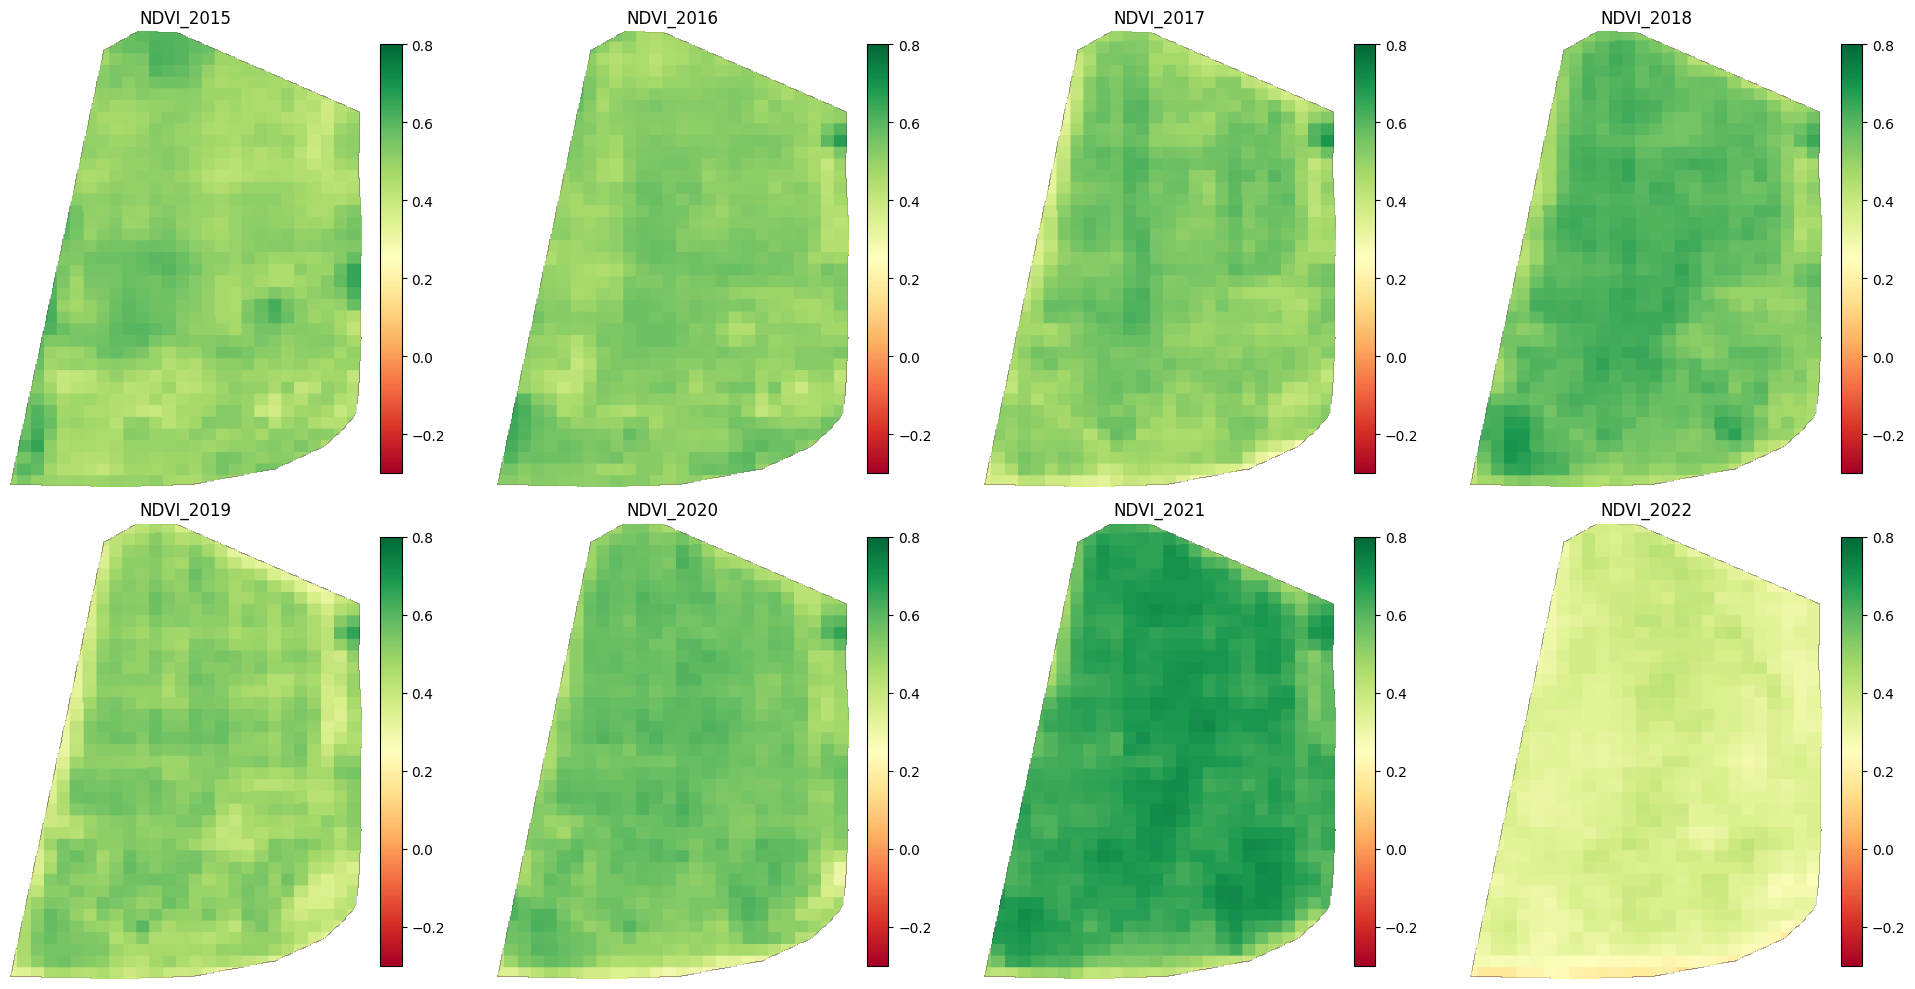

In [ ]:
## NDVI Plots
import matplotlib.pyplot as plt
import rasterio

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# List of NDVI tifs
tif_paths = ['/content/drive/MyDrive/Logan_Updated_Indices/NDVI_2015.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/NDVI_2016.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/NDVI_2017.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/NDVI_2018.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/NDVI_2019.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/NDVI_2020.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/NDVI_2021.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/NDVI_2022.tif']

# Loop through the tifs and plot each one on a subplot
for i, tif_path in enumerate(tif_paths):
    with rasterio.open(tif_path) as src:
        ax = axs.ravel()[i]
        ax.imshow(src.read(1), cmap='RdYlGn')
        ax.set_title(tif_path.split("/")[-1][0:-4])
        ax.set_axis_off()
        # Add colorbar
        cbar = fig.colorbar(ax.imshow(src.read(1), cmap='RdYlGn', vmin = -0.3, vmax = 0.8), ax=ax, fraction=0.046, pad=0.04)
        # Add neat line
        ax.set_frame_on(True)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


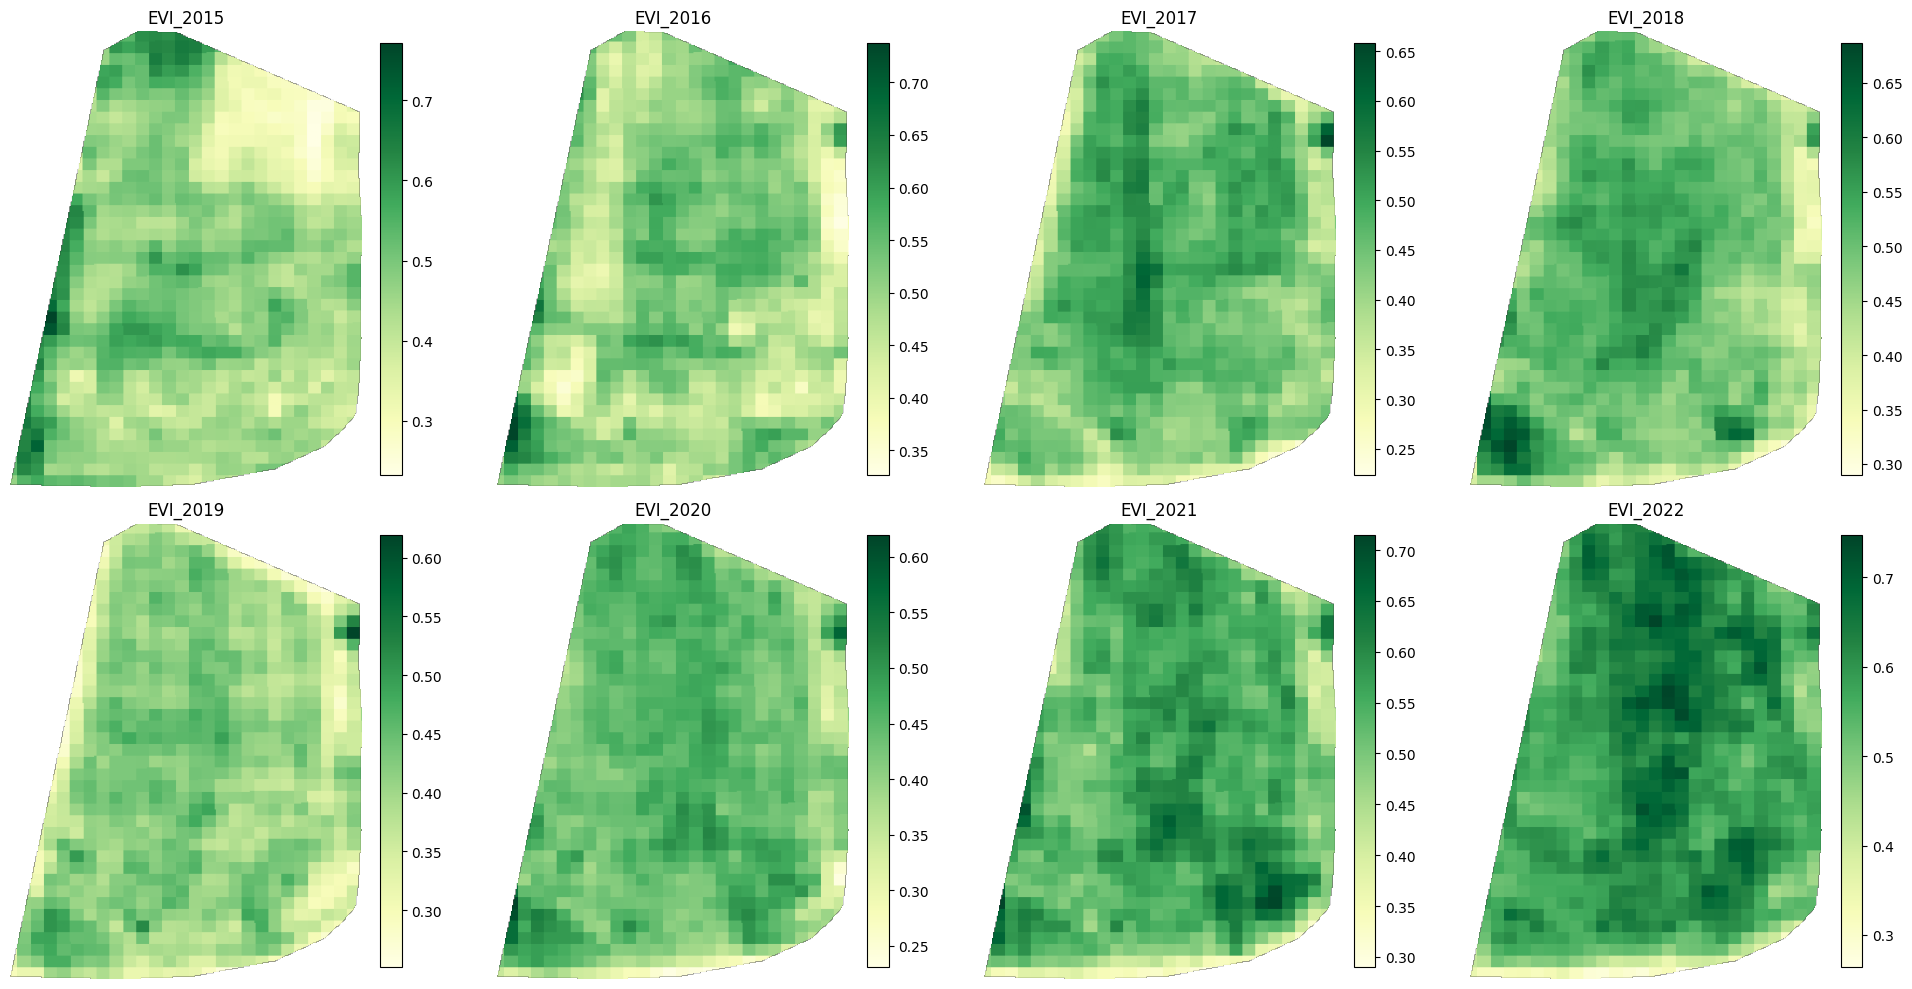

In [ ]:
## EVI Plots
import matplotlib.pyplot as plt
import rasterio

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# List of NDVI tifs
tif_paths = ['/content/drive/MyDrive/Logan_Updated_Indices/EVI_2015.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/EVI_2016.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/EVI_2017.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/EVI_2018.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/EVI_2019.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/EVI_2020.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/EVI_2021.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/EVI_2022.tif']

# Loop through the tifs and plot each one on a subplot
for i, tif_path in enumerate(tif_paths):
    with rasterio.open(tif_path) as src:
        ax = axs.ravel()[i]
        ax.imshow(src.read(1), cmap='YlGn')
        ax.set_title(tif_path.split("/")[-1][0:-4])
        ax.set_axis_off()
        # Add colorbar
        cbar = fig.colorbar(ax.imshow(src.read(1), cmap='YlGn'), ax=ax, fraction=0.046, pad=0.04)
        # Add neat line
        ax.set_frame_on(True)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

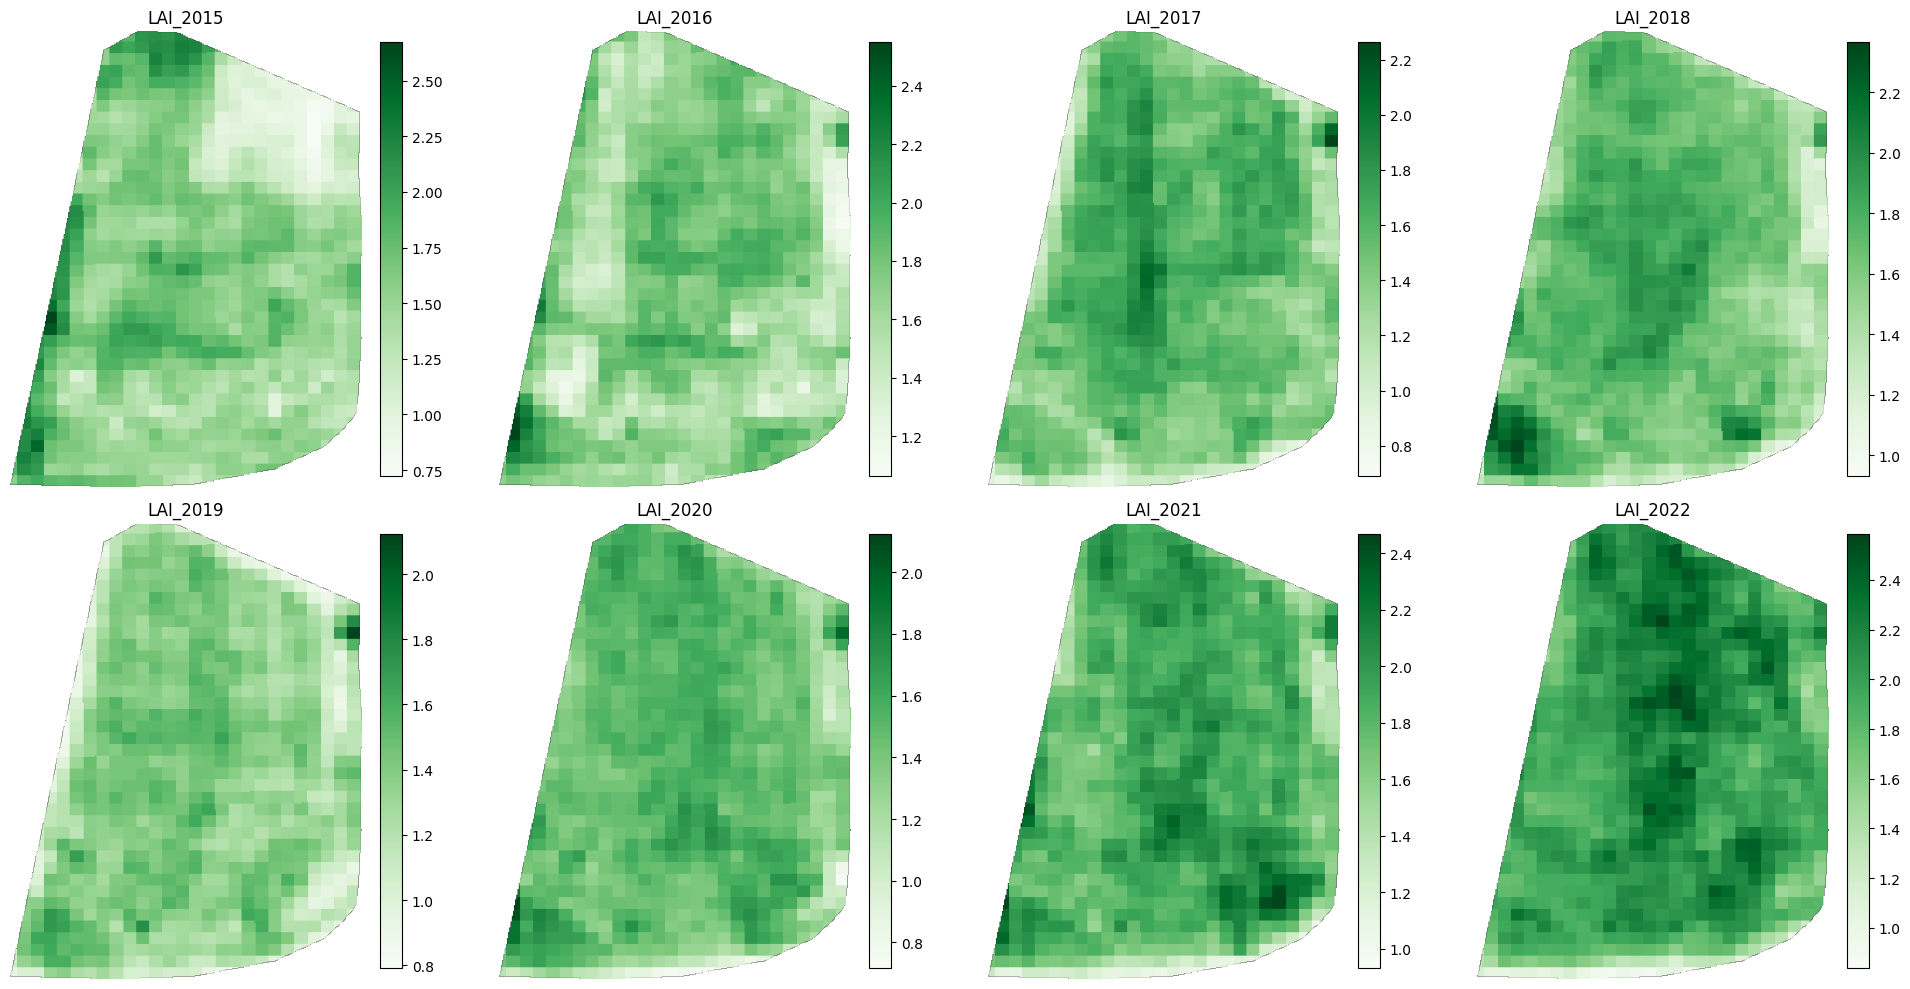

In [ ]:
## LAI Plots
import matplotlib.pyplot as plt
import rasterio

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# List of NDVI tifs
tif_paths = ['/content/drive/MyDrive/Logan_Updated_Indices/LAI_2015.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/LAI_2016.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/LAI_2017.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/LAI_2018.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/LAI_2019.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/LAI_2020.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/LAI_2021.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/LAI_2022.tif']

# Loop through the tifs and plot each one on a subplot
for i, tif_path in enumerate(tif_paths):
    with rasterio.open(tif_path) as src:
        ax = axs.ravel()[i]
        ax.imshow(src.read(1), cmap='Greens')
        ax.set_title(tif_path.split("/")[-1][0:-4])
        ax.set_axis_off()
        # Add colorbar
        cbar = fig.colorbar(ax.imshow(src.read(1), cmap='Greens'), ax=ax, fraction=0.046, pad=0.04)
        # Add neat line
        ax.set_frame_on(True)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

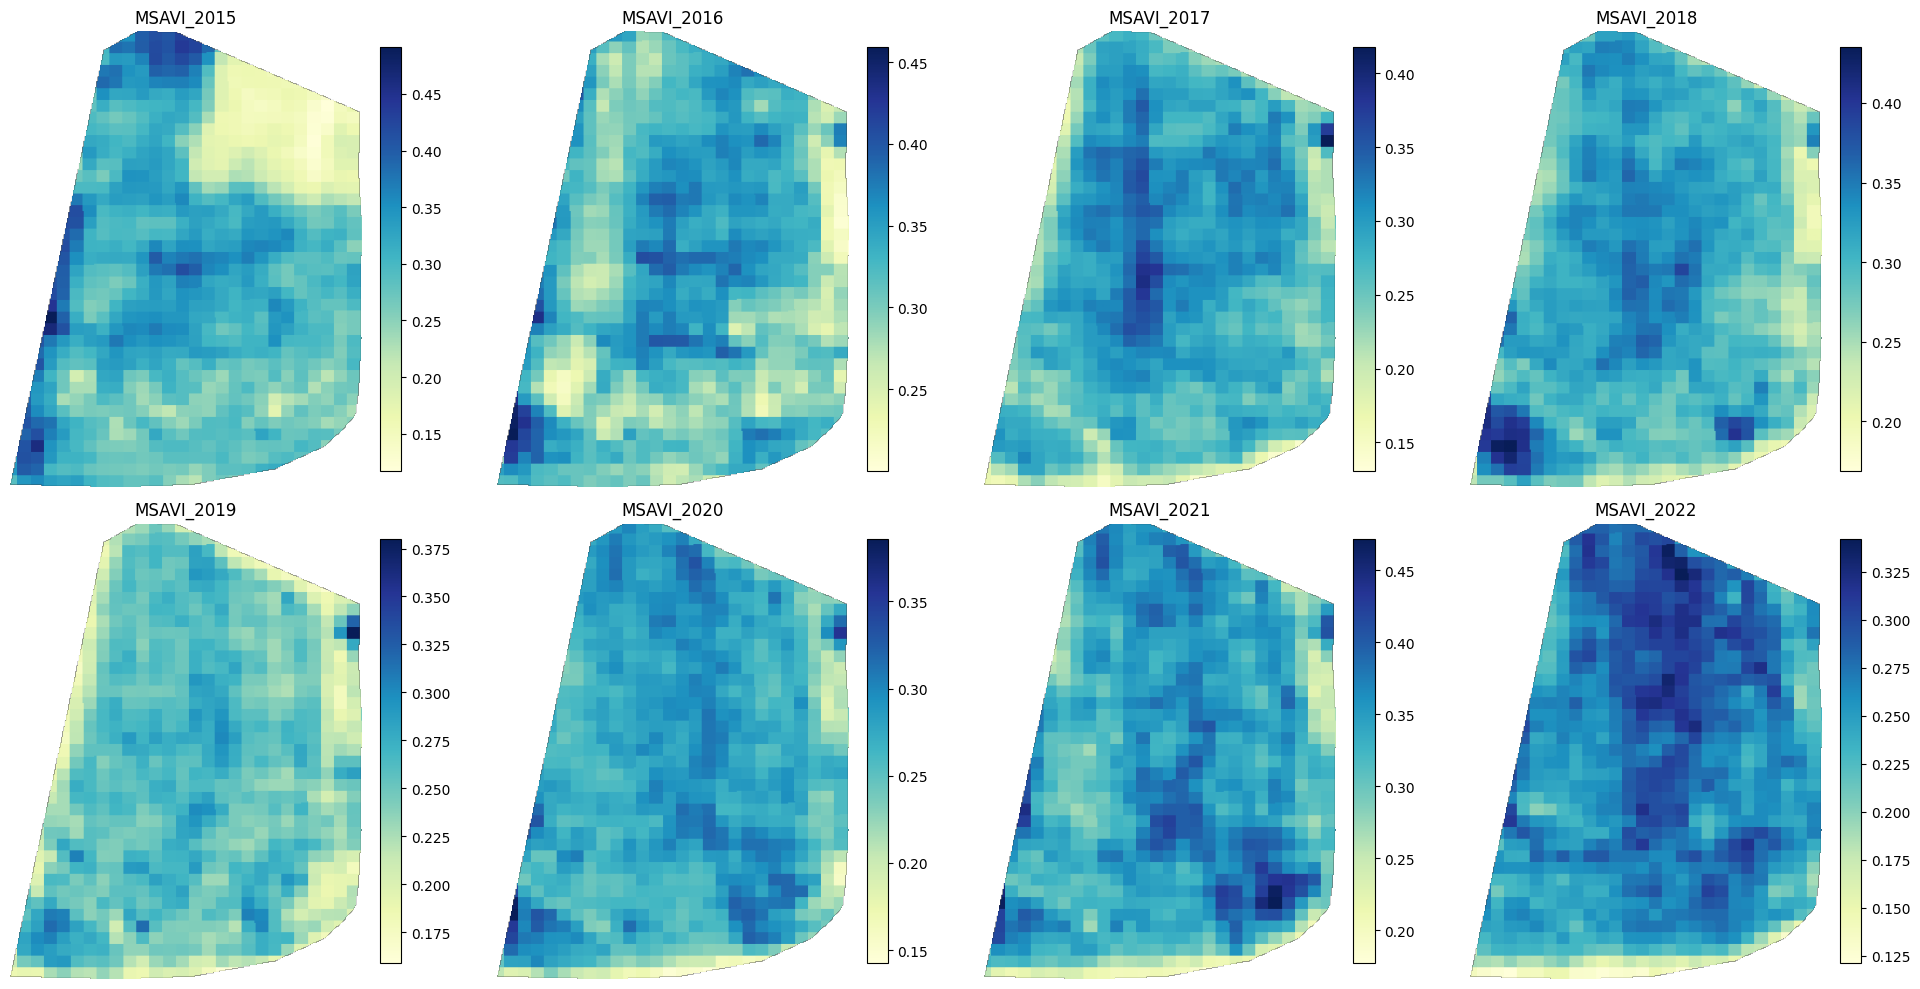

In [ ]:
# OSAVI
import matplotlib.pyplot as plt
import rasterio

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# List of NDVI tifs
tif_paths = ['/content/drive/MyDrive/Logan_Updated_Indices/MSAVI_2015.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/MSAVI_2016.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/MSAVI_2017.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/MSAVI_2018.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/MSAVI_2019.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/MSAVI_2020.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/MSAVI_2021.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/MSAVI_2022.tif']

# Loop through the tifs and plot each one on a subplot
for i, tif_path in enumerate(tif_paths):
    with rasterio.open(tif_path) as src:
        ax = axs.ravel()[i]
        ax.imshow(src.read(1), cmap='YlGnBu')
        ax.set_title(tif_path.split("/")[-1][0:-4])
        ax.set_axis_off()
        # Add colorbar
        cbar = fig.colorbar(ax.imshow(src.read(1), cmap='YlGnBu'), ax=ax, fraction=0.046, pad=0.04)
        # Add neat line
        ax.set_frame_on(True)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

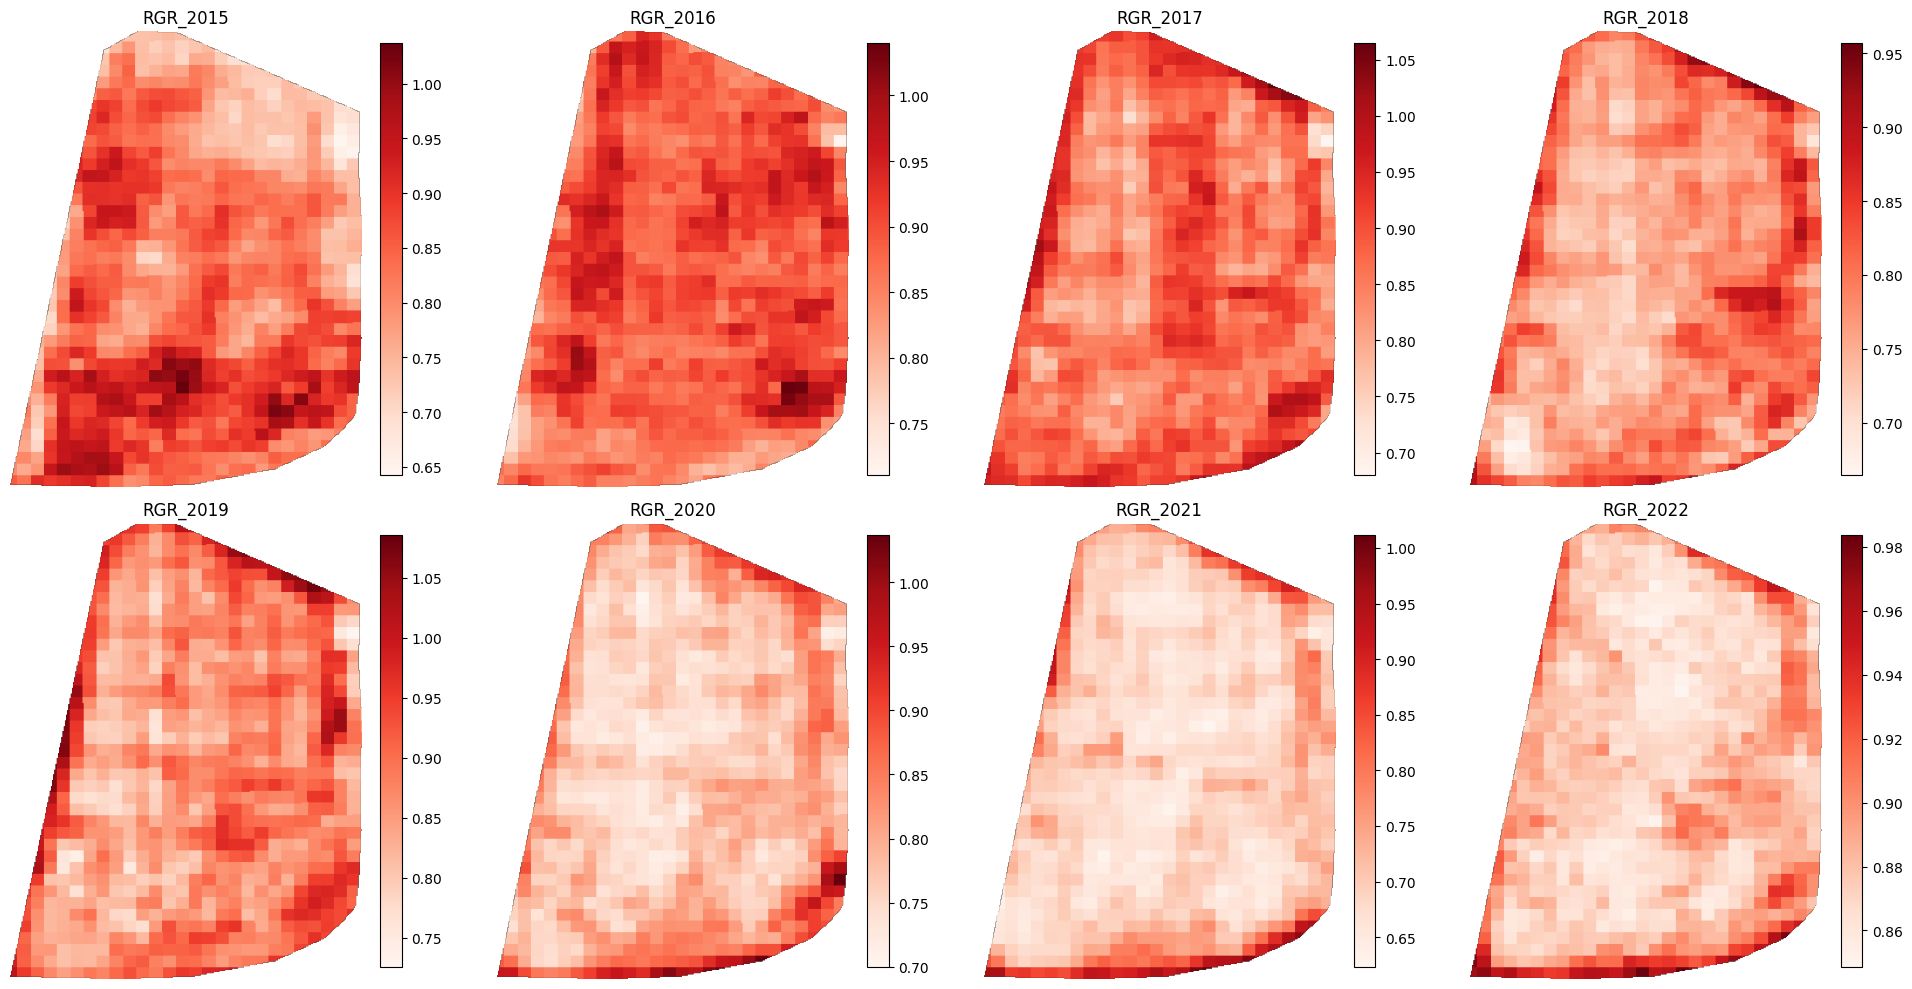

In [ ]:
# AGB
import matplotlib.pyplot as plt
import rasterio

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# List of NDVI tifs
tif_paths = ['/content/drive/MyDrive/Logan_Updated_Indices/RGR_2015.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/RGR_2016.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/RGR_2017.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/RGR_2018.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/RGR_2019.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/RGR_2020.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/RGR_2021.tif',
             '/content/drive/MyDrive/Logan_Updated_Indices/RGR_2022.tif']

# Loop through the tifs and plot each one on a subplot
for i, tif_path in enumerate(tif_paths):
    with rasterio.open(tif_path) as src:
        ax = axs.ravel()[i]
        ax.imshow(src.read(1), cmap='Reds')
        ax.set_title(tif_path.split("/")[-1][0:-4])
        ax.set_axis_off()
        # Add colorbar
        cbar = fig.colorbar(ax.imshow(src.read(1), cmap='Reds'), ax=ax, fraction=0.046, pad=0.04)
        # Add neat line
        ax.set_frame_on(True)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

###**Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Define the independent variables (NDVI, EVI, LAI, RGR, RGI, B8, B4, B3, B2)
X = df_all[['NDVI', 'MSAVI', 'EVI', 'LAI', 'RGR', 'B8', 'B4', 'B3', 'B2']]

# Define the dependent variable (AGB)
y = df_all['AGB']

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and fit linear regression model
reg = LinearRegression().fit(X_train, y_train)

# Make predictions on test data
y_pred = reg.predict(X_test)

In [ ]:
# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error: ", mae)
print("Mean Squared Error: ", mse)
print("R-Squared: ", r2)

Mean Absolute Error:  0.5198113347564431
Mean Squared Error:  0.6183139593437731
R-Squared:  0.9980722448020669


In [ ]:
# Obtain the regression coefficients and intercept
coefficients = reg.coef_
intercept = reg.intercept_

print("Coefficients: ", coefficients)
print("y-intercept: ", intercept)

Coefficients:  [ 2.45582697e+01 -4.83039566e+01  1.97086436e+00  7.13058724e+00
 -1.72308285e+02 -2.40526734e-03  2.02085583e-02 -1.13775719e-02
 -1.04635852e-02]
y-intercept:  202.73524146146605


Our equation for the regression model is:
$$AGB = 24.5583NDVI - 48.3039MSAVI + 1.9708EVI + 7.1305LAI - 172.3082RGR -0.002405B8+ 0.0202B4 - 0.01137B3 - 0.01046B2 + 202.7352$$

where AGB is the dependent variable and NDVI, MSAVI, EVI, LAI, RGR, B8, B4, B3, B2 are the independent variables

Let's use the above equation to predict AGB for Nathan Campus. We have the dataframe for Nathan Campus, generated via a similar script.

In [ ]:
# Nathan Dataframe- (The validation dataset)
nathan_df = pd.read_csv("/content/drive/MyDrive/Griffith Logan/Nathan_Campus/df_nathan.csv")
nathan_df

,Unnamed: 0.1,Unnamed: 0,X,Y,grid_code,B8,B4,B3,B2,NDVI,MSAVI,EVI,LAI,RGR,RGI,AGB,year
0,0,0,153.052078,-27.551573,0.013475,1888,962,969,1123,0.324912,0.490400,0.250609,0.788703,0.992776,0.003625,15.033816,2015
1,1,1,153.052078,-27.551483,0.020936,1841,761,821,1009,0.415065,0.586572,0.305447,0.987108,0.926918,0.037927,24.380867,2015
2,2,2,153.052170,-27.551483,0.021611,1986,1000,975,1110,0.330208,0.496412,0.255150,0.805131,1.025641,-0.012658,10.596684,2015
3,3,3,153.055206,-27.551565,0.025497,1962,1216,1233,1346,0.234739,0.380164,0.203536,0.618393,0.986212,0.006942,15.937561,2015
4,4,4,153.051971,-27.551573,0.028413,1705,644,748,942,0.451682,0.622218,0.311912,1.010498,0.860963,0.074713,34.404897,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18067,18067,2254,153.052368,-27.549858,0.344990,3313,2225,2420,2902,0.196461,0.328370,0.555329,1.891179,0.919421,0.041981,25.485552,2022
18068,18068,2255,153.052078,-27.549858,0.345588,3117,1844,2284,2684,0.256601,0.408367,0.785608,2.724332,0.807356,0.106589,43.091116,2022
18069,18069,2256,153.052078,-27.549679,0.354306,3379,2266,2515,2979,0.197166,0.329355,0.600648,2.055143,0.900994,0.052081,28.237906,2022
18070,18070,2257,153.051971,-27.549679,0.356162,3315,2136,2436,2908,0.216291,0.355622,0.682134,2.349960,0.876847,0.065617,31.926315,2022


###**Validation**

In [ ]:
# Get the validation independent variables
X_val = nathan_df[['NDVI', 'MSAVI', 'EVI', 'LAI', 'RGR', 'B8', 'B4', 'B3', 'B2']]
# Get the validation dependent variable
y_val = nathan_df['AGB']


# Make predictions on validation data using the linear regression model
y_val_pred = reg.predict(X_val)

print("Mean Absolute Error: ", mean_absolute_error(y_val, y_val_pred))
print("Mean Squared Error: ", mean_squared_error(y_val, y_val_pred))
print("R2 Score: ", r2_score(y_val, y_val_pred))

Mean Absolute Error:  1.276954668404968
Mean Squared Error:  10.738081496113539
R2 Score:  0.9728746219549996


In [ ]:
# Apply the equation above to predict AGB
nathan_df["AGB_Predicted"] = 2.45582697e+01*nathan_df["NDVI"] - 4.83039566e+01*nathan_df["MSAVI"] + 1.97086436e+00*nathan_df["EVI"] + 7.13058724e+00*nathan_df["LAI"] - 1.72308285e+02*nathan_df["RGR"] - 2.40526734e-03*nathan_df["B8"] + 2.02085583e-02*nathan_df["B4"] - 1.13775719e-02*nathan_df["B3"] - 1.04635852e-02*nathan_df["B2"] + 202.73524146146605
nathan_df

,Unnamed: 0.1,Unnamed: 0,X,Y,grid_code,B8,B4,B3,B2,NDVI,MSAVI,EVI,LAI,RGR,RGI,AGB,year,AGB_Predicted
0,0,0,153.052078,-27.551573,0.013475,1888,962,969,1123,0.324912,0.490400,0.250609,0.788703,0.992776,0.003625,15.033816,2015,14.204580
1,1,1,153.052078,-27.551483,0.020936,1841,761,821,1009,0.415065,0.586572,0.305447,0.987108,0.926918,0.037927,24.380867,2015,23.571595
2,2,2,153.052170,-27.551483,0.021611,1986,1000,975,1110,0.330208,0.496412,0.255150,0.805131,1.025641,-0.012658,10.596684,2015,9.107339
3,3,3,153.055206,-27.551565,0.025497,1962,1216,1233,1346,0.234739,0.380164,0.203536,0.618393,0.986212,0.006942,15.937561,2015,16.756591
4,4,4,153.051971,-27.551573,0.028413,1705,644,748,942,0.451682,0.622218,0.311912,1.010498,0.860963,0.074713,34.404897,2015,33.787550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18067,18067,2254,153.052368,-27.549858,0.344990,3313,2225,2420,2902,0.196461,0.328370,0.555329,1.891179,0.919421,0.041981,25.485552,2022,26.950509
18068,18068,2255,153.052078,-27.549858,0.345588,3117,1844,2284,2684,0.256601,0.408367,0.785608,2.724332,0.807356,0.106589,43.091116,2022,46.868292
18069,18069,2256,153.052078,-27.549679,0.354306,3379,2266,2515,2979,0.197166,0.329355,0.600648,2.055143,0.900994,0.052081,28.237906,2022,30.137164
18070,18070,2257,153.051971,-27.549679,0.356162,3315,2136,2436,2908,0.216291,0.355622,0.682134,2.349960,0.876847,0.065617,31.926315,2022,34.930124


In [ ]:
# Let's calculate the performance metrics for the Nathan dataset
# AGB - y_actual
# AGB_predicted - y_pred
y_actual = nathan_df["AGB"]
y_pred = nathan_df["AGB_Predicted"]

# Calculate performance metrics
mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("Mean Absolute Error in the (validation dataset): ", mae)
print("Mean Squared Error (validation dataset): ", mse)
print("R-Squared (validation dataset): ", r2)

Mean Absolute Error in the (validation dataset):  1.276954669332231
Mean Squared Error (validation dataset):  10.738081516356916
R-Squared (validation dataset):  0.972874621903863


**Let's run a correlation analysis to determine the impact of each independent variable**

In [ ]:
# Calculate the correlation matrix based on the pearson correlation
corr_matrix = X.corr(method='pearson')

In [ ]:
# Calculate correlation matrix
corr_matrix = pd.concat([X, y], axis=1).corr(method='pearson')

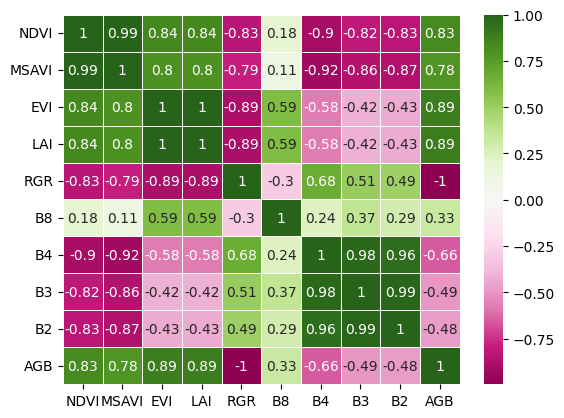

In [ ]:
# Visualizing it with seaborn
sns.heatmap(corr_matrix, cmap="PiYG", annot=True, linewidth=.5)
plt.show()

The purpose of running the correlation analysis is to understand how the different independent variables correlate with each other. In regression analysis, we prefer to use variables that are more correlated as these tend to have a bigger impact on the model. Read [this](https://www.statology.org/how-to-read-a-correlation-matrix/) article for further information on correlation.

**Stepwise Regression**

Stepwise regression is a process that helps determine which factors are important and which are not based on their p-values. It is categorized into either:

*   Forward stepwise regression or
*   Backward stepwise regression

Read this [article](https://towardsdatascience.com/stepwise-regression-tutorial-in-python-ebf7c782c922) for further information on stepwise regression and its significance



###**Stepwise Regression**

In [ ]:
import statsmodels.api as smf

# Define the model
model = smf.OLS(y, X)

# Fit the model using a full model with all possible predictors
result = model.fit()

# Print the summary of the full model
print(result.summary())

# Perform the stepwise regression
step_model = smf.OLS(y, X).fit()
step_model.summary()


                            OLS Regression Results                            
Dep. Variable:                    AGB   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.238e+05
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:12:32   Log-Likelihood:                -8073.4
No. Observations:                6784   AIC:                         1.616e+04
Df Residuals:                    6775   BIC:                         1.623e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NDVI          24.4796      1.906     12.846      0.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AGB   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.238e+05
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:12:32   Log-Likelihood:                -8073.4
No. Observations:                6784   AIC:                         1.616e+04
Df Residuals:                    6775   BIC:                         1.623e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NDVI          24.4796      1.906     12.846      0.000      20.744      28.215
MSAVI        -49.0927      1.577    -31.123      0.000     -52.185     -46.001
EVI         6252.5829     24.315    257.145      0.000    6204.917    6300.249
LAI        -1719.9685      6.724   -255.784      0.000   -1733.150   -1706.787
RGR         -172.8480      0.902   -191.702      0.000    -174.615    -171.080
B8            -0.0027      0.000    -18.314      0.000      -0.003      -0.002
B4             0.0216      0.001     37.389      0.000       0.020       0.023
B3            -0.0117      0.001    -16.347      0.000      -0.013      -0.010
B2            -0.0113      0.000    -41.327      0.000      -0.012      -0.011
==============================================================================
Omnibus:                     1861.702   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24549.961
Skew:                           0.941   Prob(JB):                         0.00
Kurtosis:                      12.128   Cond. No.                     1.02e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We have R-squared of 1.

Wuth such a high accuracy we immediately begin suspecting overfitting on our model. (We will need to perform further analysis on this to clear the concerns) Also, at a confidence level of 5%, ie 0.05, based on the results of this regression, we would drop NDVI, and B4 from our model.

Let's remove them before proceeding with cross-validation to address the suspected overfitting problem.

In [ ]:
'''# We're doing a backward stepwise regression. Let's remove NDVI first and examine the p-values
X.drop(columns=["NDVI"], inplace=True)
'''

'# We\'re doing a backward stepwise regression. Let\'s remove NDVI first and examine the p-values\nX.drop(columns=["NDVI"], inplace=True)\n'

In [ ]:
X

,NDVI,MSAVI,EVI,LAI,RGR,B8,B4,B3,B2
0,0.515416,0.680189,0.441433,1.479104,0.905435,2605,833,920,1009
1,0.452498,0.623015,0.398100,1.322325,0.926686,2515,948,1023,1115
2,0.515416,0.680189,0.441433,1.479104,0.905435,2605,833,920,1009
3,0.401760,0.573175,0.348488,1.142828,1.021858,2629,1122,1098,1140
4,0.508012,0.673710,0.458420,1.540564,0.859528,2682,875,1018,1077
...,...,...,...,...,...,...,...,...,...
6779,0.234920,0.380429,0.480269,1.619612,0.926166,3685,2283,2465,2678
6780,0.294314,0.454740,0.449754,1.509210,0.957459,3096,1688,1763,2053
6781,0.220321,0.361054,0.386735,1.281208,0.945657,3459,2210,2337,2486
6782,0.223406,0.365187,0.405388,1.348695,0.941152,3502,2223,2362,2527


In [ ]:
# Define the model
model = smf.OLS(y, X)

# Fit the model using a full model with all possible predictors
result = model.fit()

# Print the summary of the full model
print(result.summary())

# Perform the stepwise regression
step_model = smf.OLS(y, X).fit()
step_model.summary()

                            OLS Regression Results                            
Dep. Variable:                    AGB   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.238e+05
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:12:32   Log-Likelihood:                -8073.4
No. Observations:                6784   AIC:                         1.616e+04
Df Residuals:                    6775   BIC:                         1.623e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NDVI          24.4796      1.906     12.846      0.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AGB   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.238e+05
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:12:32   Log-Likelihood:                -8073.4
No. Observations:                6784   AIC:                         1.616e+04
Df Residuals:                    6775   BIC:                         1.623e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NDVI          24.4796      1.906     12.846      0.000      20.744      28.215
MSAVI        -49.0927      1.577    -31.123      0.000     -52.185     -46.001
EVI         6252.5829     24.315    257.145      0.000    6204.917    6300.249
LAI        -1719.9685      6.724   -255.784      0.000   -1733.150   -1706.787
RGR         -172.8480      0.902   -191.702      0.000    -174.615    -171.080
B8            -0.0027      0.000    -18.314      0.000      -0.003      -0.002
B4             0.0216      0.001     37.389      0.000       0.020       0.023
B3            -0.0117      0.001    -16.347      0.000      -0.013      -0.010
B2            -0.0113      0.000    -41.327      0.000      -0.012      -0.011
==============================================================================
Omnibus:                     1861.702   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24549.961
Skew:                           0.941   Prob(JB):                         0.00
Kurtosis:                      12.128   Cond. No.                     1.02e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After dropping the NDVI column, all the variables fall within a p-value of 0.05, hence should consequently be used in other models. We still, however, have the overfitting concern. Let's now use Cross-validation(CV) while running the regression.

###**Cross-Validation**

In [ ]:
from sklearn.model_selection import cross_val_score


# Create the linear regression object
reg = LinearRegression()

# Perform cross-validation with 5 folds
scores = cross_val_score(reg, X, y, cv=10)

# Print the mean and standard deviation of the cross-validation scores
print("Cross-validation scores: {}".format(scores))
print("Mean: {:.2f}".format(scores.mean()))
print("Standard deviation: {:.2f}".format(scores.std()))

Cross-validation scores: [0.99594296 0.99033535 0.99725226 0.99714238 0.9936999  0.98206262
 0.9977283  0.99774641 0.99780912 0.98633812]
Mean: 0.99
Standard deviation: 0.01


The results of this cross-validated model somewhat clears our concerns on overfitting. However, let's explore some regularization techniques. In this case, Ridge and Lasso regression.

Let's incorporate CV within the models to improve fully address our concerns.

###**Ridge**

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the Ridge model
ridge = Ridge(alpha=0.01)

# Fit the model to the training data
ridge.fit(X_train, y_train)

# Evaluate the model on the test data
test_score = ridge.score(X_test, y_test)
print("Test score: {:.4f}".format(test_score))

# Perform k-fold cross-validation
scores = cross_val_score(ridge, X, y, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Mean cross-validation score: {:.4f}".format(scores.mean()))


Test score: 0.9981
Cross-validation scores: [0.99110763 0.99755994 0.99368716 0.9979735  0.99535568]
Mean cross-validation score: 0.9951


At alpha=0.1, accuracy = 0.9993, at alpha = 1, accuracy = 0.9971; alpha = 100, accuracy = 0.9224.

Not only do these results address our concerns on overfitting but confirms our model performance. Increasing the alpha value reduces the model complexity thus causing our model to begin underfitting.

**Validation**

In [ ]:
# Make predictions on validation data
y_val_pred = ridge.predict(X_val)

print("------------Ridge Validation------------")
print("Mean Absolute Error: ", mean_absolute_error(y_val, y_val_pred))
print("Mean Squared Error: ", mean_squared_error(y_val, y_val_pred))
print("R2 Score: ", r2_score(y_val, y_val_pred))

------------Ridge Validation------------
Mean Absolute Error:  1.290952511222812
Mean Squared Error:  10.81155139549864
R2 Score:  0.9726890302553585


###**Lasso**

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Create the Lasso model
lasso = Lasso(alpha=0.1)

# Fit the model to the training data
lasso.fit(X_train, y_train)

# Evaluate the model on the test data
test_score = lasso.score(X_test, y_test)
print("Test score: {:.4f}".format(test_score))

# Perform k-fold cross-validation
scores = cross_val_score(lasso, X_scaled, y, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Mean cross-validation score: {:.4f}".format(scores.mean()))


Test score: 0.9953
Cross-validation scores: [0.98213086 0.9945499  0.98660869 0.99550293 0.99634172]
Mean cross-validation score: 0.9910


In [ ]:
# Scale the features because they are scaled in the real model
X_val_scaled = scaler.fit_transform(X_val)

# Make predictions on validation data
y_val_pred = lasso.predict(X_val_scaled)

print("------------Lasso Validation------------")
print("Mean Absolute Error: ", mean_absolute_error(y_val, y_val_pred))
print("Mean Squared Error: ", mean_squared_error(y_val, y_val_pred))
print("R2 Score: ", r2_score(y_val, y_val_pred))

------------Lasso Validation------------
Mean Absolute Error:  2.417381918993924
Mean Squared Error:  10.182623607710399
R2 Score:  0.9742777594909241


At this point we're sure that we don't have overfitting. Both the regularization models are adequate proof.

Let's run other regression algorithms

###**Random Forest**

In [ ]:
# RF Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the pipeline with the StandardScaler and the RandomForestRegressor
pipe = Pipeline([("scaler", StandardScaler()), ("rf", RandomForestRegressor())])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipe.predict(X_test)

# Calculate the performance metrics
score = pipe.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mape = mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Score: {:.4f}".format(score))
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.4f}".format(mape))
print("RMSE: {:.4f}".format(rmse))


Score: 0.9999
MAE: 0.0193
MAPE: 0.0009
RMSE: 0.1467


In [ ]:
# access the feature importances of the RandomForestRegressor
feature_importances = pipe.named_steps['rf'].feature_importances_

# access the intercept of the StandardScaler
intercept = pipe.named_steps['scaler'].mean_

print("Feature importances:", feature_importances)
print("y-intercept: ", intercept)

Feature importances: [3.22428591e-06 3.74572851e-06 3.18615353e-06 4.54503528e-06
 9.99966258e-01 3.78128923e-06 5.13125777e-06 1.56929622e-06
 8.55921163e-06]
y-intercept:  [4.99122125e-01 6.52356270e-01 5.28818717e-01 1.79526612e+00
 8.47886384e-01 3.17897620e+03 1.09592839e+03 1.26274473e+03
 1.32239280e+03]


**Validation**

In [ ]:
# Scale the features because they are scaled in the real model
#X_val_scaled = scaler.fit_transform(X_val)

# Make predictions on validation data
y_val_pred = pipe.predict(X_val)

print("------------RF Validation------------")
print("Mean Absolute Error: ", mean_absolute_error(y_val, y_val_pred))
print("Mean Squared Error: ", mean_squared_error(y_val, y_val_pred))
print("R2 Score: ", r2_score(y_val, y_val_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("MAPE: ", mean_absolute_percentage_error(y_val, y_val_pred))

------------RF Validation------------
Mean Absolute Error:  0.048305859705238416
Mean Squared Error:  0.07061393624482692
R2 Score:  0.999821622725011
RMSE:  0.2657328286923295
MAPE:  0.06983973070524871


###**Support Vector**

In [ ]:
# Support Vector Regressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# define the model
svr_model = SVR(kernel='linear', C=1)

# create a pipeline with the scaler and model
pipe = Pipeline([('scaler', StandardScaler()), ('svr', svr_model)])

# fit the pipeline to the training data
pipe.fit(X_train, y_train)

# evaluate the model on the test data
y_pred = pipe.predict(X_test)
score = pipe.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print the results
print("Score: {:.4f}".format(score))
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.4f}".format(mape))
print("RMSE: {:.4f}".format(rmse))


Score: 0.9976
MAE: 0.4933
MAPE: 0.0237
RMSE: 0.8698


**Validation**

In [ ]:
# Make predictions on validation data
y_val_pred = pipe.predict(X_val)

print("------------Support Vector Validation------------")
print("Mean Absolute Error: ", mean_absolute_error(y_val, y_val_pred))
print("Mean Squared Error: ", mean_squared_error(y_val, y_val_pred))
print("R2 Score: ", r2_score(y_val, y_val_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("MAPE: ", mean_absolute_percentage_error(y_val, y_val_pred))

------------Support Vector Validation------------
Mean Absolute Error:  1.5746401451991203
Mean Squared Error:  8.932105081442764
R2 Score:  0.9774366839030328
RMSE:  2.9886627580646774
MAPE:  0.5636204227153798


###**KNN**

In [ ]:
# KNN Regressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the KNN model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_scaled, y)

# Predict on new data
y_pred = knn.predict(X_scaled)

# Get the performance metrics
score = knn.score(X_scaled, y)
mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print("Score: {:.4f}".format(score))
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.4f}".format(mape))
print("RMSE: {:.4f}".format(rmse))


Score: 0.9972
MAE: 0.6416
MAPE: 0.0261
RMSE: 0.9393


In [ ]:
# Scale the features because they are scaled in the real model
X_val_scaled = scaler.fit_transform(X_val)

# Make predictions on validation data
y_val_pred = knn.predict(X_val_scaled)

print("------------KNN Validation------------")
print("Mean Absolute Error: ", mean_absolute_error(y_val, y_val_pred))
print("Mean Squared Error: ", mean_squared_error(y_val, y_val_pred))
print("R2 Score: ", r2_score(y_val, y_val_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("MAPE: ", mean_absolute_percentage_error(y_val, y_val_pred))

------------KNN Validation------------
Mean Absolute Error:  3.928132510777559
Mean Squared Error:  27.034704733118154
R2 Score:  0.9317078580111162
RMSE:  5.1994908147931325
MAPE:  1.866794055002027


###**XGBoost**

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the pipeline with the StandardScaler and the XGBRegressor
pipe = Pipeline([("scaler", StandardScaler()), ("xgb", XGBRegressor())])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipe.predict(X_test)

# Calculate the performance metrics
score = pipe.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Score: {:.4f}".format(score))
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.4f}".format(mape))
print("RMSE: {:.4f}".format(rmse))


Score: 0.9998
MAE: 0.0891
MAPE: 0.0042
RMSE: 0.2625


In [ ]:
# Make predictions on validation data
y_val_pred = pipe.predict(X_val)

print("------------XGBoost Validation------------")
print("Mean Absolute Error: ", mean_absolute_error(y_val, y_val_pred))
print("Mean Squared Error: ", mean_squared_error(y_val, y_val_pred))
print("R2 Score: ", r2_score(y_val, y_val_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("MAPE: ", mean_absolute_percentage_error(y_val, y_val_pred))

------------XGBoost Validation------------
Mean Absolute Error:  0.23572913161100142
Mean Squared Error:  0.888747710090544
R2 Score:  0.9977549418272194
RMSE:  0.9427341672446926
MAPE:  0.3860672702022389


Let's present the results for our models. We shall use a library called prettytables

In [ ]:
# Install prettytable
!pip install prettytable

In [ ]:
from prettytable import PrettyTable

# Create a table
x = PrettyTable()
x.field_names = ["Model", "Score", "MAE", "MAPE(%)", "RMSE"]

# Add rows to the table
x.add_row(["Random Forest", 0.9999, 0.0180, 0.10, 0.1312])
x.add_row(["Suppport Vector", 0.9976,0.4933, 2.37, 0.8698])
x.add_row(["KNN", 0.9972, 0.6416, 2.61, 0.9393])
x.add_row(["XGBoost", 0.9998, 0.1337, 0.54, 0.2198])

# Print the table
print("Model(s) Metrics")
print(x)


Model(s) Metrics
+-----------------+--------+--------+---------+--------+
|      Model      | Score  |  MAE   | MAPE(%) |  RMSE  |
+-----------------+--------+--------+---------+--------+
|  Random Forest  | 0.9999 | 0.018  |   0.1   | 0.1312 |
| Suppport Vector | 0.9976 | 0.4933 |   2.37  | 0.8698 |
|       KNN       | 0.9972 | 0.6416 |   2.61  | 0.9393 |
|     XGBoost     | 0.9998 | 0.1337 |   0.54  | 0.2198 |
+-----------------+--------+--------+---------+--------+


In [ ]:
# Create a table
x = PrettyTable()
x.field_names = ["Model", "Score", "MAE", "MAPE(%)", "RMSE"]

# Add rows to the table
x.add_row(["Random Forest", 0.9998, 0.0500, 7.74, 0.2773])
x.add_row(["Suppport Vector", 0.9774,1.5746, 56.36, 2.9887])
x.add_row(["KNN", 0.9317, 3.9281, 186.68, 5.1995])
x.add_row(["XGBoost", 0.9998, 0.1554, 56.36, 2.9887])

# Print the table
print("Validation Metrics")
print(x)

Validation Metrics
+-----------------+--------+--------+---------+--------+
|      Model      | Score  |  MAE   | MAPE(%) |  RMSE  |
+-----------------+--------+--------+---------+--------+
|  Random Forest  | 0.9998 |  0.05  |   7.74  | 0.2773 |
| Suppport Vector | 0.9774 | 1.5746 |  56.36  | 2.9887 |
|       KNN       | 0.9317 | 3.9281 |  186.68 | 5.1995 |
|     XGBoost     | 0.9998 | 0.1554 |  56.36  | 2.9887 |
+-----------------+--------+--------+---------+--------+


We have run 4 regression models:


1.   Random Forest Regression
2.   Support Vector Regression
3.   KNN Regression
4.   XGBoost Regression

All the models have performance scores of >99% and would therefore all be suitable for predicting AGB based on the independent variables we have.

It is plausible to integrate other factors, and if possible field data to further train the models.

Random Forest Regression model has the highest performance score, the lowest MAE, MAPE and RMSE.It is therefore, **most suited** for handling our problem.



